In [65]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb

In [66]:
# Loading data
current_working_directory = Path.cwd()
path = (current_working_directory / "../../data/cleaned_main.csv").resolve()
df_main = pd.read_csv(path)
path = (current_working_directory / "../../data/cleaned_variants.csv").resolve()
df_variants = pd.read_csv(path)

# Data preparation

In [67]:
# Create a column that combines name and subcategory for merger
df_main["name_and_subcategory"] = df_main["master_name"] + " " +  df_main["subcategory"]
df_variants["name_and_subcategory"] = df_variants["master_name"] + " " +  df_variants["subcategory"]


In [68]:
# Merge average price data into main modeling dataset
df_prices = df_variants.groupby("name_and_subcategory")["price"].mean().reset_index()
df_prices["price"] = round(df_prices["price"], 2)
df_prices.rename(columns={"price": "avg_price"}, inplace=True)
df_main = df_main.merge(df_prices, on="name_and_subcategory", how="left")

# Drop unnecessary metadata and verbose experience-related columns
df_main = df_main.drop(["master_name", "details", "Verified Buyer", "Verified Reviewer", "Unverified"], axis=1)
df_main = df_main.drop(columns=[col for col in df_main.columns if "size_ag" in col or "experience" in col], axis=1)

# Reorder columns for cleaner structure in downstream modeling
order = ["main_category", "subcategory", "name_and_subcategory", "avg_price", "review_amount", "rating", "size"]
df_main = df_main[order]

# Remove rows with missing values to ensure model input consistency
df_main = df_main.dropna()

# Encode "size" column to ordinal numerical format for modeling
size_map = {
    "True to size" : "1",
    "Small": "2",
    "Big": "3",
    "Too Small": "4",
    "Too Big": "5"
}
df_main["size"] = df_main["size"].replace(size_map)

df_main.head()

,main_category,subcategory,name_and_subcategory,avg_price,review_amount,rating,size
0,Woman's,Womens-sandals,Lumina Womens-sandals,76.62,8,4.9,3
1,Woman's,Womens-sandals,Linear Womens-sandals,109.95,18,4.9,1
2,Woman's,Womens-sandals,Bigschmonj Womens-sandals,59.95,16,4.3,3
3,Woman's,Womens-sandals,Bigmona Womens-sandals,99.95,343,4.7,1
4,Woman's,Womens-sandals,Bigschmona Womens-sandals,99.95,40,4.5,1


# Multilinear regression

In [69]:
X = df_main[["avg_price", "rating", "size"]]
y = df_main["review_amount"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [70]:
lr = LinearRegression()
lr.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [71]:
lr.score(X_test, y_test)

-0.00548355867124517

As expected Scraped dataset shows that it dosent have enough variables to constructs a linear regression model, so dataset will be completed with random generation of real-world like data to showcase
predicitve modeling

In [72]:
from datetime import datetime, timedelta

# Simulate date range
dates = pd.date_range(start="2024-01-01", end="2024-04-30")

simulated_rows = []

for _, row in df_main.iterrows():
    for date in dates:
        month = date.month
        weekday = date.weekday()

        # Discount simulation
        discount = np.random.choice([0, 10, 20], p=[0.7, 0.2, 0.1])

        # Ad status simulation
        ad_status = np.random.choice([0, 1], p=[0.8, 0.2])

        # Holiday status smulation
        holiday = 1 if np.random.rand() < 0.08 else 0

        # Weekend boost
        weekend_boost = 1.2 if weekday >= 5 else 1.0

        # Base demand
        base_sales = (
            100
            - row["avg_price"] * 0.5
            + row["rating"] * 15
        )

        # Sales modifiers
        base_sales *= (1 + discount / 100)
        if ad_status:
            base_sales *= 1.2
        if holiday:
            base_sales *= 1.3
        base_sales *= weekend_boost

        # Add noise to make it more realistic
        sales = int(np.random.normal(base_sales, 5))
        sales = max(0, sales)

        # Append row
        simulated_rows.append({
            "product": row["name_and_subcategory"],
            "subcategory": row["subcategory"],
            "avg_price": row["avg_price"],
            "rating": row["rating"],
            "date": date,
            "month": month,
            "weekday": weekday,
            "discount_percent": discount,
            "ad_status": ad_status,
            "holiday_event": holiday,
            "sales": sales
        })

# Convert to DataFrame
simulated_df = pd.DataFrame(simulated_rows)

simulated_df.head()

,product,subcategory,avg_price,rating,date,month,weekday,discount_percent,ad_status,holiday_event,sales
0,Lumina Womens-sandals,Womens-sandals,76.62,4.9,2024-01-01,1,0,0,0,0,139
1,Lumina Womens-sandals,Womens-sandals,76.62,4.9,2024-01-02,1,1,0,0,0,124
2,Lumina Womens-sandals,Womens-sandals,76.62,4.9,2024-01-03,1,2,0,0,0,134
3,Lumina Womens-sandals,Womens-sandals,76.62,4.9,2024-01-04,1,3,0,1,0,156
4,Lumina Womens-sandals,Womens-sandals,76.62,4.9,2024-01-05,1,4,0,0,0,141


In [73]:
# Separate data into target variable and predictors
X = simulated_df[["avg_price", "rating", "month",
       "weekday", "discount_percent", "ad_status",
       "holiday_event",]]
y = simulated_df["sales"]
# Create standartization scaler
scaler = StandardScaler()
# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
# Apply scaler and poly features
X_scaled = scaler.fit_transform(X)
X_poly_scaled = poly.fit_transform(X_scaled)
# Split data into train and test batches
X_train, X_test, y_train, y_test = train_test_split(X_poly_scaled, y, test_size=0.2, random_state=9)

In [74]:
# Create ridge model and fit it with train data
ridge = Ridge(alpha = 1.0)
ridge.fit(X_train, y_train)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [75]:
# Calculate model metrics
y_pred = ridge.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² Score: {r2:.3f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

R² Score: 0.948
MAE: 5.89
MSE: 55.68
RMSE: 7.46


### Actual Values vs Model Predictions

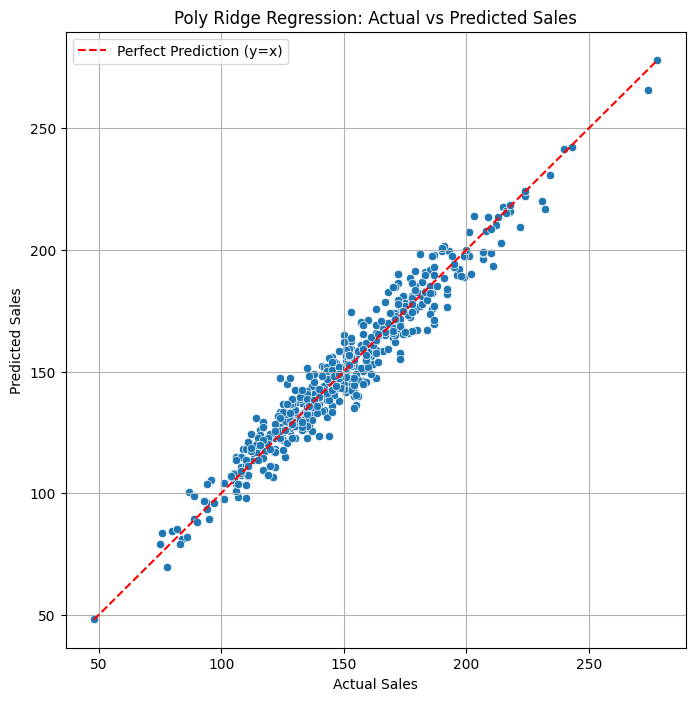

In [76]:
# Reset indices for cleaner display
y_test_reset = y_test.reset_index(drop=True)
y_pred_series = pd.Series(y_pred, name="Predicted Sales")

# Create a cleaner DataFrame
prediction_df = pd.DataFrame({
    "Actual Sales": y_test_reset,
    "Predicted Sales": y_pred_series
})

# Use reproducible random sampling
prediction_df = prediction_df.sample(n=500, random_state=13)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=prediction_df["Actual Sales"], y=prediction_df["Predicted Sales"])
plt.plot([prediction_df["Actual Sales"].min(), prediction_df["Actual Sales"].max()],
         [prediction_df["Actual Sales"].min(), prediction_df["Actual Sales"].max()],
         "r--", label="Perfect Prediction (y=x)")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Poly Ridge Regression: Actual vs Predicted Sales")
plt.legend()
plt.grid(True)
plt.show()

### Coefficients weight

In [77]:
# Get the names of the expanded features
feature_names = poly.get_feature_names_out(X.columns)

# Now you can match coefficients to names:
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": ridge.coef_
})

# View the top influential features
coef_df.sort_values(by="Coefficient", key=abs, ascending=False)
coef_df.head(5)

,Feature,Coefficient
0,avg_price,-20.393780
1,rating,9.150145
2,month,-0.018121
3,weekday,9.940649
4,discount_percent,9.610422


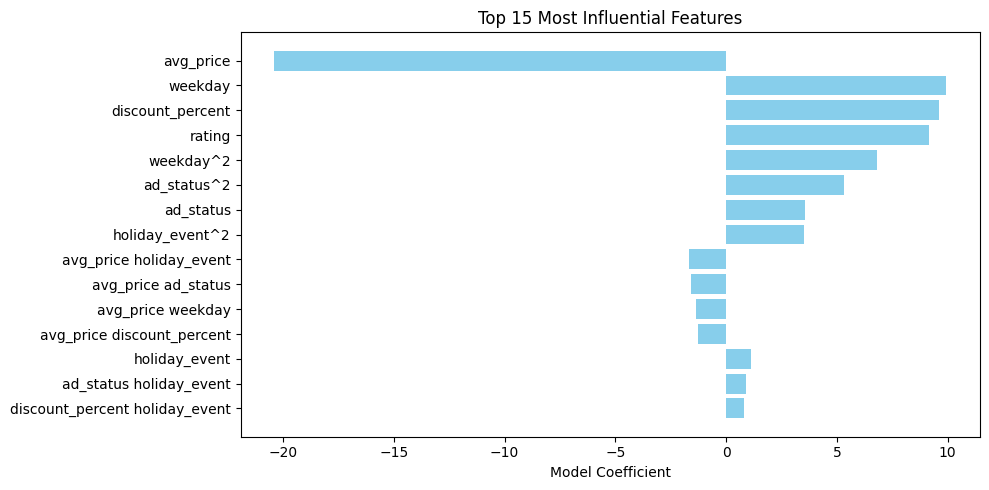

In [78]:
top_features = coef_df.reindex(coef_df["Coefficient"].abs().sort_values(ascending=False).index)[:15]

plt.figure(figsize=(10, 5))
plt.barh(top_features["Feature"], top_features["Coefficient"], color="skyblue")
plt.xlabel("Model Coefficient")
plt.title("Top 15 Most Influential Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Predicting sales on completely new data

In [79]:
def generate_new_prediction_input(n=5):
    np.random.seed(9)  # for reproducibility

    rows = []
    today = datetime.today()

    for _ in range(n):
        # Random values (based on your original feature logic)
        avg_price = np.round(np.random.uniform(40, 150), 2)
        rating = np.round(np.random.uniform(3.5, 5.0), 1)
        date = today + timedelta(days=np.random.randint(0, 30))
        month = date.month
        weekday = date.weekday()
        discount_percent = np.random.choice([0, 10, 20], p=[0.4, 0.3, 0.3])
        ad_status = np.random.choice([0, 1], p=[0.5, 0.5])
        holiday_event = np.random.choice([0, 1], p=[0.5, 0.5])

        rows.append({
            "avg_price": avg_price,
            "rating": rating,
            "month": month,
            "weekday": weekday,
            "discount_percent": discount_percent,
            "ad_status": ad_status,
            "holiday_event": holiday_event
        })

    return pd.DataFrame(rows)

In [80]:
# Generate 5 new rows
new_data = generate_new_prediction_input(30)

# If you used polynomial features + scaling:
# Scale → Transform
new_scaled = scaler.transform(new_data)
new_poly_scaled = poly.transform(new_scaled)



# Predict
predictions = ridge.predict(new_poly_scaled)

# Combine into a final result DataFrame
results_df = new_data.copy()
results_df["Predicted Sales"] = predictions.astype(int)

results_df.sample(5)

,avg_price,rating,month,weekday,discount_percent,ad_status,holiday_event,Predicted Sales
13,75.17,4.3,7,1,0,1,0,149
9,148.56,3.6,7,0,10,0,0,91
2,136.64,4.9,8,6,20,1,0,185
21,137.08,4.4,7,6,10,1,0,158
0,41.14,4.3,8,4,0,0,0,152


# Random Forest model

In [81]:
# Split data into target variable and predictors
X = simulated_df[["avg_price", "rating", "month",
       "weekday", "discount_percent", "ad_status",
       "holiday_event",]]
y = simulated_df["sales"]
# Split data into trai and test batches
X_train, X_test, y_train,  y_test = train_test_split(X, y)

In [82]:
# Set up Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=9)

# Fit on training data
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [83]:
# Get model metrics
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² Score: {r2:.3f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


R² Score: 0.971
MAE: 4.43
MSE: 31.22
RMSE: 5.59


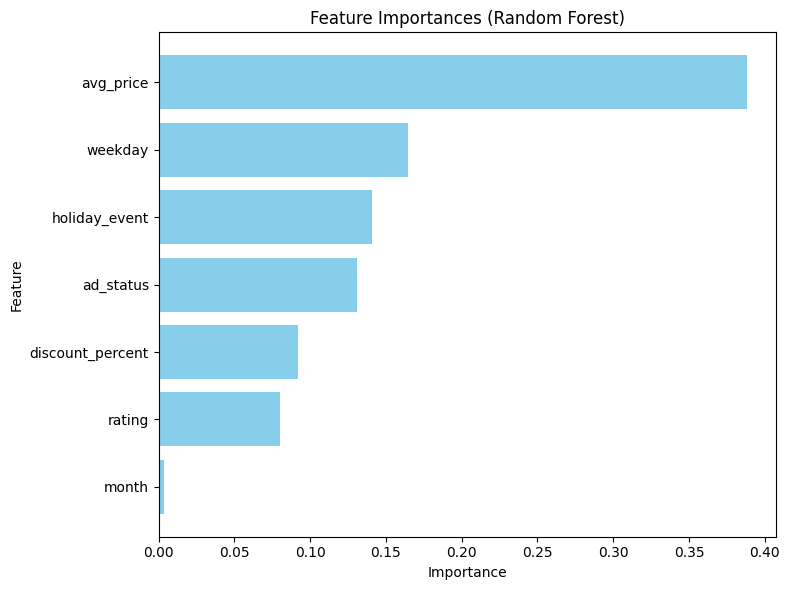

In [84]:
# Get model"s top features
top_features = pd.Series(rf.feature_importances_, index=X.columns).reset_index()
top_features.columns = ["feature", "importance"]
top_features = top_features.sort_values(by = "importance", ascending=True)
# Plot
plt.figure(figsize=(8, 6))
plt.barh(top_features["feature"], top_features["importance"], color="skyblue")  
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

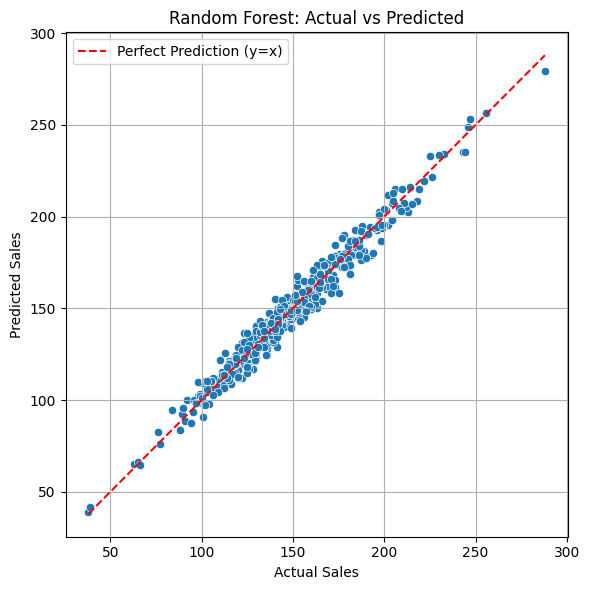

In [85]:
# Randomly sample 500 indices from y_test
rng = np.random.default_rng(seed=13)
sample_indices = rng.choice(y_test.index, size=500, replace=False)

# Subset actual and predicted values
y_test_sample = y_test.loc[sample_indices]
y_pred_sample = pd.Series(y_pred, index=y_test.index).loc[sample_indices]

# Combine into a single DataFrame
results_df = pd.DataFrame({
    "Actual Sales": y_test_sample,
    "Predicted Sales": y_pred_sample
})

# Create the plot
plt.figure(figsize=(6, 6))
sns.scatterplot(data=results_df, x="Actual Sales", y="Predicted Sales")
plt.plot(
    [results_df["Actual Sales"].min(), results_df["Actual Sales"].max()],
    [results_df["Actual Sales"].min(), results_df["Actual Sales"].max()],
    "r--", label="Perfect Prediction (y=x)"
)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Random Forest: Actual vs Predicted")
plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()

In [86]:
# Predict on a new data
predictions = rf.predict(new_data)

# Combine into a final result DataFrame
results_df = new_data.copy()
results_df["Predicted Sales"] = predictions.astype(int)

results_df.sample(5)

,avg_price,rating,month,weekday,discount_percent,ad_status,holiday_event,Predicted Sales
12,81.26,3.8,8,4,0,0,1,151
1,136.49,3.7,7,6,0,0,0,107
10,58.65,4.7,7,6,0,0,1,217
23,127.10,4.4,7,6,20,0,0,145
26,117.42,4.3,7,5,10,0,0,140


# XGBoost


In [87]:
# Split data into target variable and predictor
simulated_df["subcategory"] = simulated_df["subcategory"].astype("category")
X = simulated_df.drop(["product", "sales", "date"], axis = 1)
y = simulated_df["sales"]
# Split data into train and test batches
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [88]:
# Set up XGBoost model
xgb_m = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    enable_categorical=True,   # enable native categorical feature support
    random_state=9
)
# Fit on training data
xgb_m.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [89]:
# Get model metrics
y_pred = xgb_m.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")


R²: 0.975
MAE: 4.094
MSE: 26.371
RMSE: 5.135


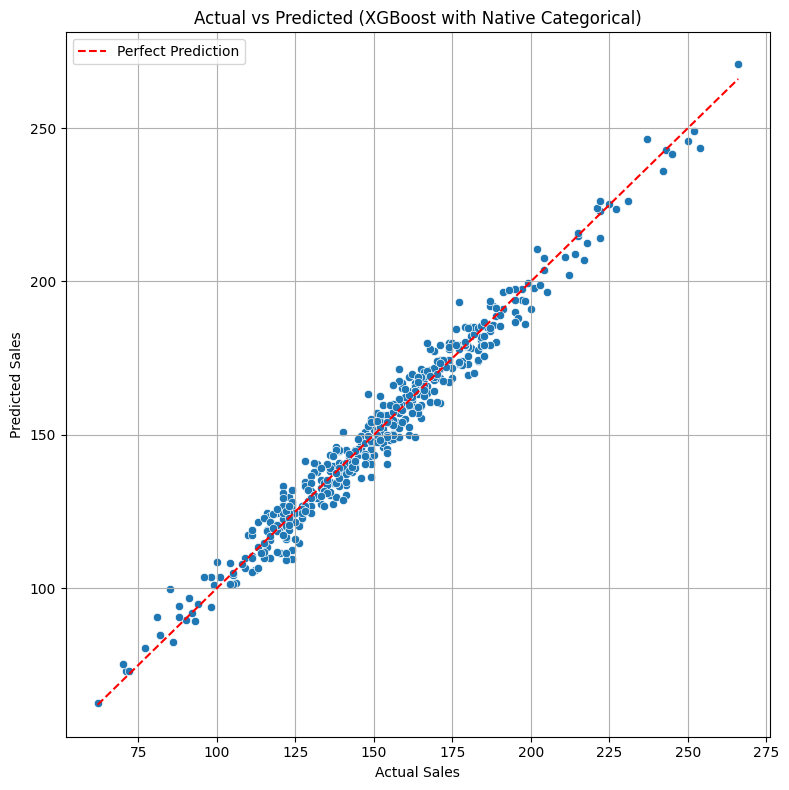

In [90]:
# Randomly sample 500 indices from y_test
rng = np.random.default_rng(seed=11)
sample_indices = rng.choice(y_test.index, size=500, replace=False)

# Subset actual and predicted values
y_test_sample = y_test.loc[sample_indices]
y_pred_sample = pd.Series(y_pred, index=y_test.index).loc[sample_indices]

# Combine into a single DataFrame
results_df = pd.DataFrame({
    "Actual Sales": y_test_sample,
    "Predicted Sales": y_pred_sample
})

# Create the plot
plt.figure(figsize=(8, 8))
sns.scatterplot(data=results_df, x="Actual Sales", y="Predicted Sales")
plt.plot(
    [results_df["Actual Sales"].min(), results_df["Actual Sales"].max()],
    [results_df["Actual Sales"].min(), results_df["Actual Sales"].max()],
    "r--",
    label="Perfect Prediction"
)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted (XGBoost with Native Categorical)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Get most important features
importance_dict = xgb_m.get_booster().get_score(importance_type="gain")
top_features = pd.DataFrame({
    "feature": list(importance_dict.keys()),
    "importance": list(importance_dict.values())
})

# Sort by importance in descending order
top_features= top_features.sort_values(by="importance", ascending=False).reset_index(drop=True)

In [92]:
fig = px.bar(top_features, x = "importance", y = "feature", log_x=True, title = "Feature Importances (XGBoost)")
fig.update_layout(
    width = 1500,
    xaxis_title = "Feature Importance",
    yaxis_title = "Feature Name",
    xaxis_tickvals = [100, 250, 500, 1000,  2000, 5000, 10000, 25000, 50000, 100000, 200000, 400000],
)
fig.show()

In [ ]:
# Get a list of subcategories and their probabilities of appearing to test XGBoost on new data which includes categorical data
subcategories_dict = simulated_df["subcategory"].value_counts().to_dict()
subcategories = list(subcategories_dict.keys())
counts = np.array(list(subcategories_dict.values()))
probabilities = counts / counts.sum()  

In [94]:
# generate random data for XGBoost testing
def generate_new_prediction_input(n=5):
    np.random.seed(9)  

    rows = []
    today = datetime.today()

    for _ in range(n):
        # Random values 
        subcats = np.random.choice(subcategories, p=probabilities)
        avg_price = np.round(np.random.uniform(40, 150), 2)
        rating = np.round(np.random.uniform(3.5, 5.0), 1)
        date = today + timedelta(days=np.random.randint(0, 30))
        month = date.month
        weekday = date.weekday()
        discount_percent = np.random.choice([0, 10, 20], p=[0.4, 0.3, 0.3])
        ad_status = np.random.choice([0, 1], p=[0.5, 0.5])
        holiday_event = np.random.choice([0, 1], p=[0.5, 0.5])

        rows.append({
            "subcategory": subcats,
            "avg_price": avg_price,
            "rating": rating,
            "month": month,
            "weekday": weekday,
            "discount_percent": discount_percent,
            "ad_status": ad_status,
            "holiday_event": holiday_event
        })

    return pd.DataFrame(rows)
rows = generate_new_prediction_input(30)
new_data = pd.DataFrame(rows)
new_data["subcategory"] = new_data["subcategory"].astype("category")

In [95]:
# Predict on a new data
predictions = xgb_m.predict(new_data)

# Combine into a final result DataFrame
results_df = new_data.copy()
results_df["Predicted Sales"] = predictions.astype(int)

results_df.sample(5)

,subcategory,avg_price,rating,month,weekday,discount_percent,ad_status,holiday_event,Predicted Sales
22,Womens-slip-on-slides,98.95,4.1,7,5,10,0,0,149
2,Womens-heels,116.90,4.4,8,3,0,1,1,169
28,Handbags-crossbody-bags,62.11,4.9,7,1,20,1,0,204
4,Kids-flower-girl-shoes,58.66,4.3,7,1,10,0,1,191
29,Womens-heels,77.38,3.9,8,0,20,1,1,218
